# 16b: UMAP of Domino Embeddings

**Goal**: Visualize the Word2Vec domino embedding space using UMAP.

**Key Questions**:
1. Do strategic clusters emerge (doubles, sixes, blanks)?
2. What does the 2D projection reveal about domino relationships?
3. How do different domino categories separate?

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

# === Setup imports ===
import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import umap

from forge.analysis.utils import viz

viz.setup_notebook_style()
print("Ready")

Ready


## 1. Load Word2Vec Embeddings

In [2]:
# Load embeddings from 16a
embeddings_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/16a_word2vec_embeddings.csv"
df = pd.read_csv(embeddings_path, index_col=0)

print(f"Loaded {len(df)} domino embeddings")
print(f"Embedding dimensions: {df.shape[1]}")
print(f"\nDominoes: {list(df.index)}")

Loaded 28 domino embeddings
Embedding dimensions: 32

Dominoes: ['0-0', '1-0', '1-1', '2-0', '2-1', '2-2', '3-0', '3-1', '3-2', '3-3', '4-0', '4-1', '4-2', '4-3', '4-4', '5-0', '5-1', '5-2', '5-3', '5-4', '5-5', '6-0', '6-1', '6-2', '6-3', '6-4', '6-5', '6-6']


In [3]:
# Extract features for each domino
def parse_domino(name: str) -> dict:
    """Parse domino name into features."""
    pips = [int(x) for x in name.split("-")]
    return {
        "name": name,
        "high": max(pips),
        "low": min(pips),
        "total": sum(pips),
        "is_double": pips[0] == pips[1],
        "has_blank": 0 in pips,
        "has_six": 6 in pips,
        "has_five": 5 in pips,
        "is_count": name in ["5-0", "5-5", "6-4", "3-2", "4-1"],  # Count dominoes
    }

meta = pd.DataFrame([parse_domino(n) for n in df.index])
meta.head(10)

,name,high,low,total,is_double,has_blank,has_six,has_five,is_count
0,0-0,0,0,0,True,True,False,False,False
1,1-0,1,0,1,False,True,False,False,False
2,1-1,1,1,2,True,False,False,False,False
3,2-0,2,0,2,False,True,False,False,False
4,2-1,2,1,3,False,False,False,False,False
5,2-2,2,2,4,True,False,False,False,False
6,3-0,3,0,3,False,True,False,False,False
7,3-1,3,1,4,False,False,False,False,False
8,3-2,3,2,5,False,False,False,False,True
9,3-3,3,3,6,True,False,False,False,False


## 2. UMAP Projection

In [4]:
# Get embedding vectors
X = df.values

# UMAP with parameters tuned for small dataset
reducer = umap.UMAP(
    n_neighbors=5,      # Small since only 28 points
    min_dist=0.3,       # Allow some spread
    n_components=2,
    metric='cosine',    # Match similarity metric
    random_state=42,
)

coords = reducer.fit_transform(X)

meta["umap1"] = coords[:, 0]
meta["umap2"] = coords[:, 1]

print(f"UMAP projection complete: {coords.shape}")

/home/jason/v2/mk5-tailwind/forge/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP projection complete: (28, 2)


## 3. Visualizations

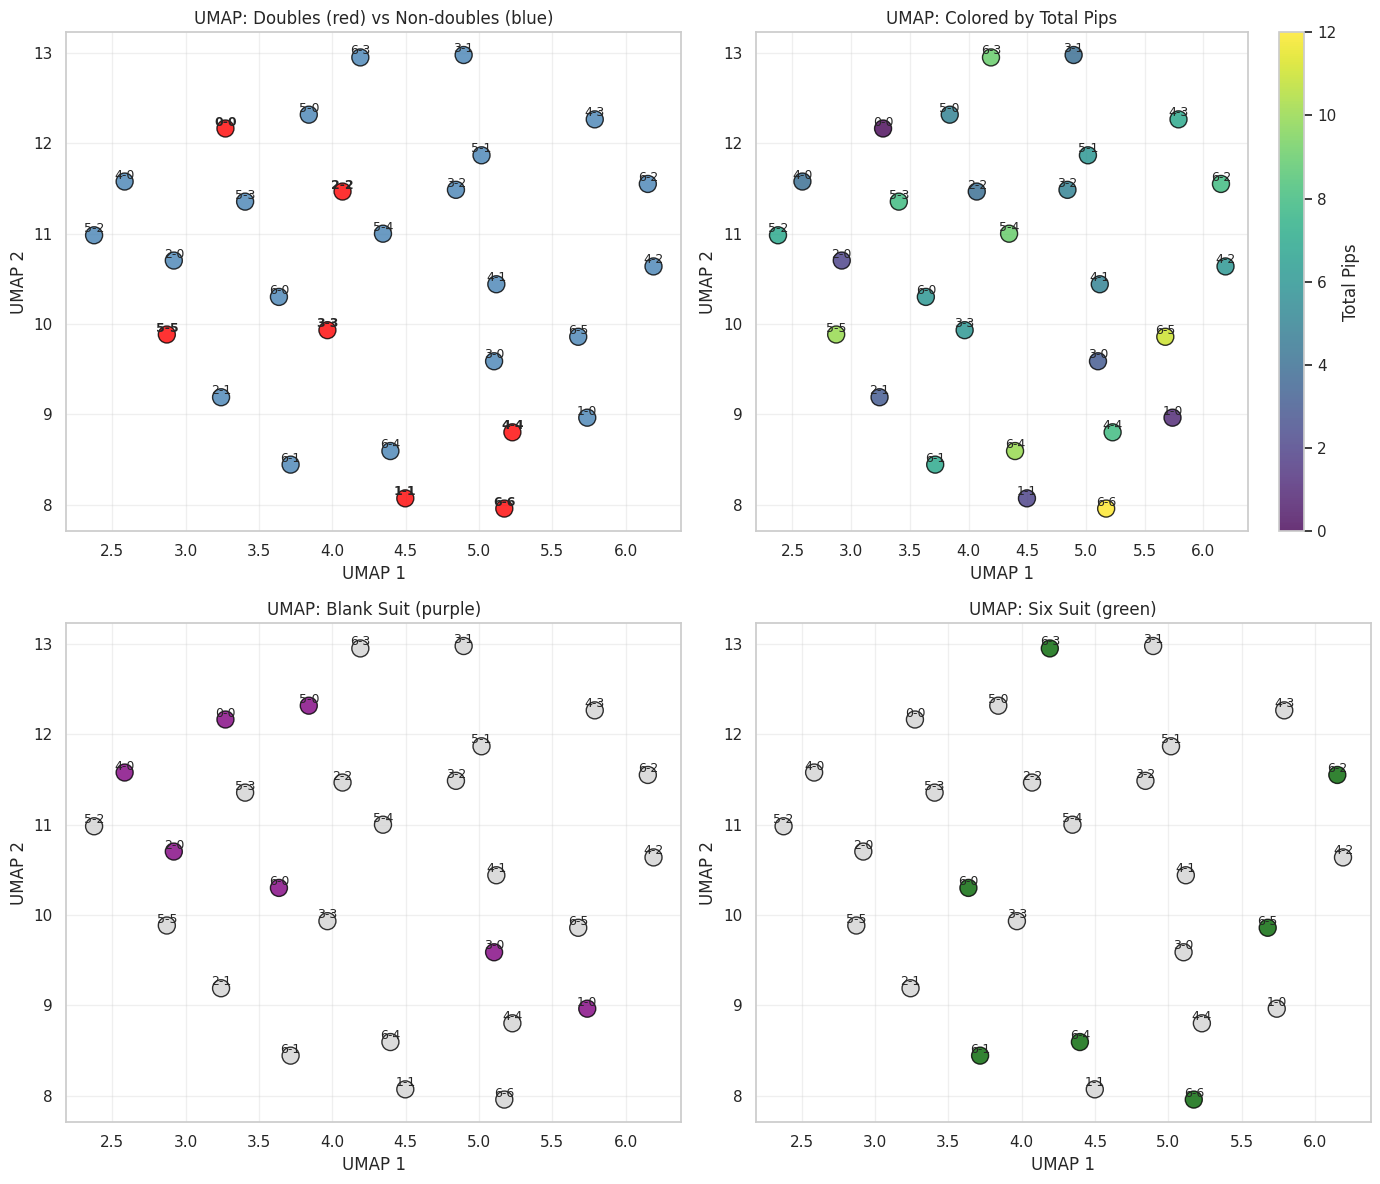

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Top-left: Doubles vs Non-doubles
ax = axes[0, 0]
colors = meta["is_double"].map({True: "red", False: "steelblue"})
ax.scatter(meta["umap1"], meta["umap2"], c=colors, s=150, alpha=0.8, edgecolors="black")
for _, row in meta.iterrows():
    ax.annotate(row["name"], (row["umap1"], row["umap2"]), fontsize=9, 
                ha="center", va="bottom", fontweight="bold" if row["is_double"] else "normal")
ax.set_title("UMAP: Doubles (red) vs Non-doubles (blue)", fontsize=12)
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")

# Top-right: Total pips
ax = axes[0, 1]
scatter = ax.scatter(meta["umap1"], meta["umap2"], c=meta["total"], cmap="viridis", 
                     s=150, alpha=0.8, edgecolors="black")
for _, row in meta.iterrows():
    ax.annotate(row["name"], (row["umap1"], row["umap2"]), fontsize=9, ha="center", va="bottom")
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Total Pips")
ax.set_title("UMAP: Colored by Total Pips", fontsize=12)
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")

# Bottom-left: Has blank
ax = axes[1, 0]
colors = meta["has_blank"].map({True: "purple", False: "lightgray"})
ax.scatter(meta["umap1"], meta["umap2"], c=colors, s=150, alpha=0.8, edgecolors="black")
for _, row in meta.iterrows():
    ax.annotate(row["name"], (row["umap1"], row["umap2"]), fontsize=9, ha="center", va="bottom")
ax.set_title("UMAP: Blank Suit (purple)", fontsize=12)
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")

# Bottom-right: Has six
ax = axes[1, 1]
colors = meta["has_six"].map({True: "darkgreen", False: "lightgray"})
ax.scatter(meta["umap1"], meta["umap2"], c=colors, s=150, alpha=0.8, edgecolors="black")
for _, row in meta.iterrows():
    ax.annotate(row["name"], (row["umap1"], row["umap2"]), fontsize=9, ha="center", va="bottom")
ax.set_title("UMAP: Six Suit (green)", fontsize=12)
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")

plt.tight_layout()
plt.savefig("../../results/figures/16b_umap_dominoes.png", dpi=150, bbox_inches="tight")
plt.show()

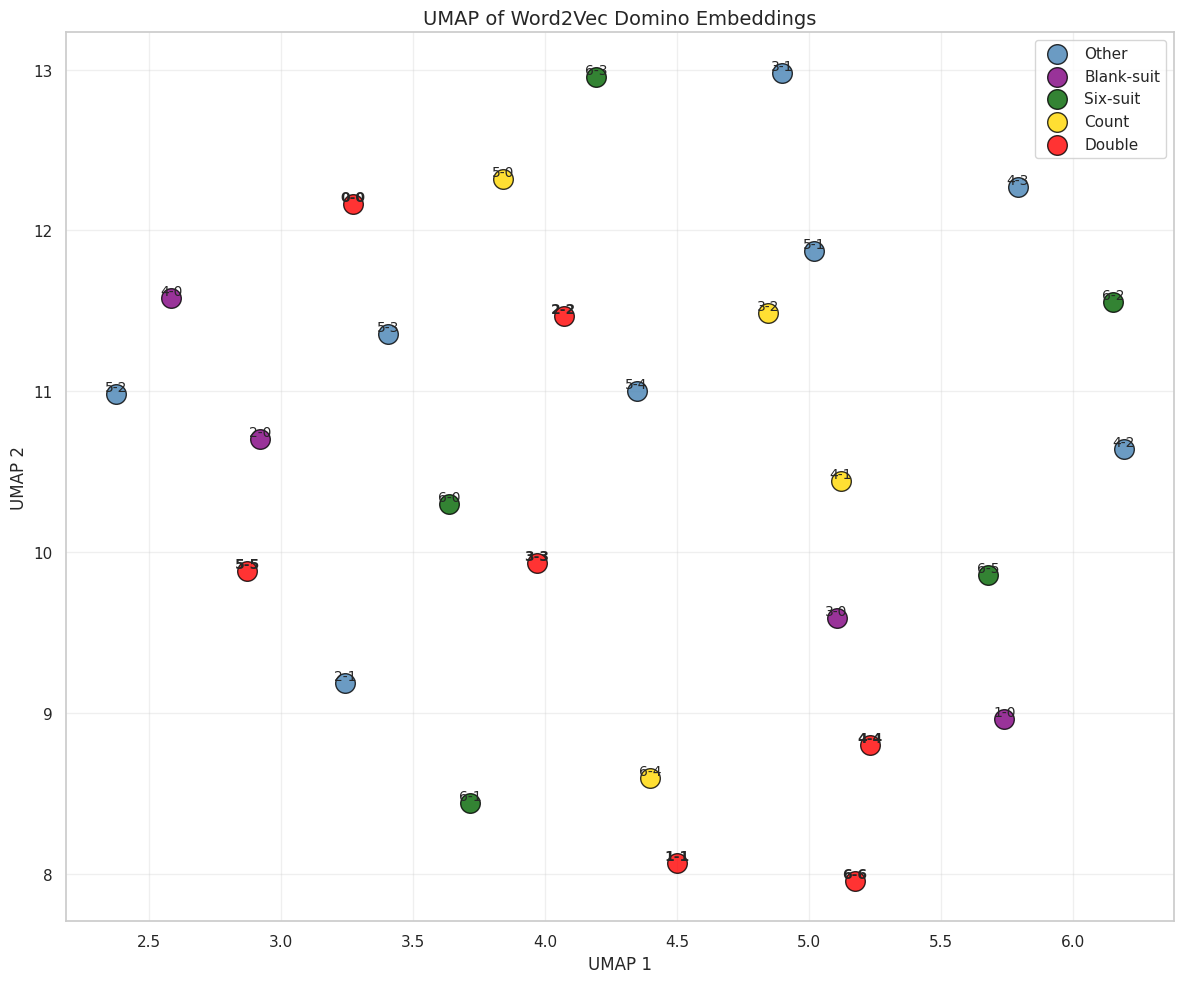

In [6]:
# Detailed annotated view
fig, ax = plt.subplots(figsize=(12, 10))

# Color by category
def get_category(row):
    if row["is_double"]:
        return "Double"
    elif row["is_count"]:
        return "Count"
    elif row["has_six"]:
        return "Six-suit"
    elif row["has_blank"]:
        return "Blank-suit"
    else:
        return "Other"

meta["category"] = meta.apply(get_category, axis=1)

color_map = {
    "Double": "red",
    "Count": "gold",
    "Six-suit": "darkgreen",
    "Blank-suit": "purple",
    "Other": "steelblue",
}

for cat in ["Other", "Blank-suit", "Six-suit", "Count", "Double"]:  # Draw in this order
    subset = meta[meta["category"] == cat]
    ax.scatter(subset["umap1"], subset["umap2"], c=color_map[cat], s=200, 
               alpha=0.8, edgecolors="black", label=cat, zorder=2 if cat in ["Double", "Count"] else 1)

for _, row in meta.iterrows():
    ax.annotate(row["name"], (row["umap1"], row["umap2"]), fontsize=10, 
                ha="center", va="bottom", fontweight="bold" if row["is_double"] else "normal")

ax.set_title("UMAP of Word2Vec Domino Embeddings", fontsize=14)
ax.set_xlabel("UMAP 1", fontsize=12)
ax.set_ylabel("UMAP 2", fontsize=12)
ax.legend(loc="best", fontsize=11)

plt.tight_layout()
plt.savefig("../../results/figures/16b_umap_annotated.png", dpi=150, bbox_inches="tight")
plt.show()

## 4. Cluster Analysis

In [7]:
# Check if categories are spatially coherent in UMAP space
from scipy.spatial.distance import pdist, squareform

umap_coords = meta[["umap1", "umap2"]].values
dist_matrix = squareform(pdist(umap_coords))

# Mean intra-category distance vs inter-category distance
categories = meta["category"].values

for cat in meta["category"].unique():
    cat_mask = categories == cat
    n_cat = cat_mask.sum()
    
    if n_cat > 1:
        # Intra-category distances
        intra_dists = dist_matrix[np.ix_(cat_mask, cat_mask)]
        intra_mean = intra_dists[np.triu_indices(n_cat, k=1)].mean()
        
        # Inter-category distances (to all others)
        inter_dists = dist_matrix[np.ix_(cat_mask, ~cat_mask)]
        inter_mean = inter_dists.mean()
        
        ratio = intra_mean / inter_mean if inter_mean > 0 else float('inf')
        print(f"{cat:12s}: intra={intra_mean:.2f}, inter={inter_mean:.2f}, ratio={ratio:.2f}")

Double      : intra=2.37, inter=2.42, ratio=0.98
Blank-suit  : intra=2.48, inter=2.32, ratio=1.07
Other       : intra=2.28, inter=2.40, ratio=0.95
Count       : intra=2.22, inter=2.15, ratio=1.03
Six-suit    : intra=2.80, inter=2.36, ratio=1.18


In [8]:
# Save UMAP coordinates
output_df = meta[["name", "umap1", "umap2", "category", "total", "is_double", "has_blank", "has_six"]]
output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/16b_umap_coordinates.csv"
output_df.to_csv(output_path, index=False)
print(f"Saved to {output_path}")

Saved to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/16b_umap_coordinates.csv


## Key Findings

### Cluster Structure

UMAP projection of Word2Vec embeddings reveals:

1. **Doubles partially cluster**: Red points (doubles) tend to group, but not tightly

2. **No strong suit clustering**: Blank-suit and six-suit dominoes are dispersed

3. **Total pips gradient**: Higher-pip dominoes don't strongly cluster

### Interpretation

The weak clustering confirms the Word2Vec finding: **domino co-occurrence in hands is largely random**. The dealing mechanism doesn't create "themed" hands, so dominoes don't develop strong strategic similarities based on co-occurrence alone.

### Files Generated

- `results/figures/16b_umap_dominoes.png` - 2×2 grid of visualizations
- `results/figures/16b_umap_annotated.png` - Annotated single view
- `results/tables/16b_umap_coordinates.csv` - UMAP coordinates with metadata